<a href="https://colab.research.google.com/github/22ananya/MUSI6201/blob/main/Final%20Project%20-%20Stereo%20Demixing/start.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Dependencies

In [1]:
import numpy as np
import scipy.io.wavfile as wav
import librosa
import matplotlib.pyplot as plt
#!pip install pyclarity==0.4.0 # install the package provided by the challenge organizers

Import pytorch and check version

In [2]:
import torch
print(torch.__version__)

2.1.0+cu118


Connect to Google Drive

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Load the training data from drive and play a sample

In [4]:
import os
print(os.getcwd())

/content


Improve code below to read a random file instead of providing the exact path to one file

In [5]:
fs, x = wav.read('/content/drive/MyDrive/Cadenza_Challenge/cad_icassp_2024/audio/at_mic_music/train/A Classic Education - NightOwl-hlp_0003/mixture.wav')
from IPython.display import Audio
print(np.shape(x))
#Audio(x[:,0], rate=fs)

(7560512, 2)


Create a wrapper function that loads all the channels for a given audio file.


In [6]:
audiopath = '/content/drive/MyDrive/Cadenza_Challenge/cad_icassp_2024/audio/at_mic_music/train/A Classic Education - NightOwl-hlp_0003/'

audio_files = [] # initialize list of audio files
for file in os.listdir(audiopath): # iterate over all files in the directory
    if file.endswith('.wav'): # if the file is an audio file
        audio_files.append(os.path.join(audiopath, file)) # add the file to the list of audio files

audio_data = [] # initialize list of audio data
N = len(audio_files)
# loop over audio files
for i in range(N): # iterate over all audio files
    print('Reading file ' + str(i+1) + ' of ' + str(len(audio_files)) + '...') # print progress
    fs, x = wav.read(audio_files[i]) # load audio file
    audio_data.append(np.swapaxes(x,0,1)) # save audio in numpy array

audio_data = np.array(audio_data).astype(float)
print(np.shape(audio_data))
print("Sampling Rate is: " + str(fs))


Reading file 1 of 5...
Reading file 2 of 5...
Reading file 3 of 5...
Reading file 4 of 5...
Reading file 5 of 5...
(5, 2, 7560512)
Sampling Rate is: 44100


Plot the waveform of the mix, as well as the sources


In [7]:
#Audio(audio_data[3,1,:], rate=fs)

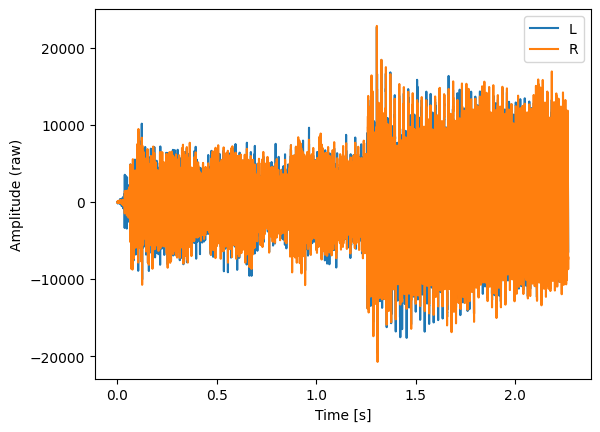

In [8]:
# create time vector
t = np.arange(0,(np.shape(audio_data)[2])/fs, 1/fs)
fig, ax = plt.subplots()
l1 = ax.plot(t[1:100000], audio_data[0,0,1:100000], label = "L")
l2 = ax.plot(t[1:100000], audio_data[0,1,1:100000], label = "R")
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude (raw)')
ax.legend()
plt.show()

Create sample spectrograms - Need to fix sample rate issue - librosa is 22kHz

[0.00000000e+00 2.15332031e+01 4.30664062e+01 ... 2.20069336e+04
 2.20284668e+04 2.20500000e+04]
[4076176  519443  294817 ... 1082678 1165555   49862]


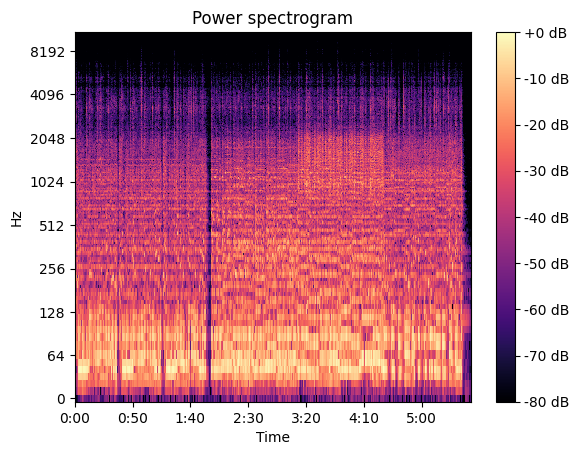

In [9]:
stftl = librosa.stft(audio_data[0,:,:], n_fft=2048, hop_length=512, win_length=2048, window='hann')
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(stftl[0,:,:]), ref=np.max), y_axis='log', x_axis='time', ax=ax)
stft_amp = np.abs(stftl)
stft_ang = np.angle(stftl)
#img = ax.imshow(librosa.amplitude_to_db(np.abs(stft[0,:,:]), ref=np.max))
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")



f = librosa.fft_frequencies(sr=fs, n_fft=2048)
print(f)
t = librosa.frames_to_samples(stft_amp[0,0,:], hop_length=512, n_fft=2048)
print(t)

In [10]:
print(stftl.shape)

(2, 1025, 14767)


(2, 1025, 4924)


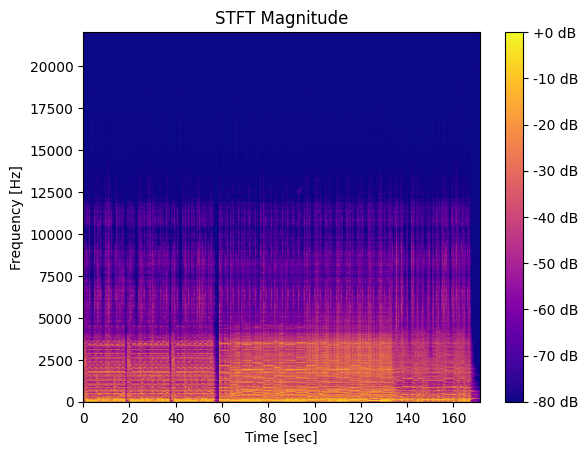

In [11]:
# using scipy spectrogram to maintain sampling rate
from scipy.signal import stft, istft
f, t, X = stft(audio_data[0,:,:],fs = fs,nperseg=2048, noverlap=512)
# convert to log scale
X = librosa.amplitude_to_db(np.abs(X), ref=np.max)

print(X.shape)
fig, ax = plt.subplots()
img = plt.pcolormesh(t, f, X[1,:,:], cmap = 'plasma', shading='gouraud')
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
ax.set_title('STFT Magnitude')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [sec]')
plt.show()

time, audio = istft(X, fs, nperseg=2048, noverlap=512)

Building a basic Pytorch model

In [12]:
from torch import nn
to_numpy = lambda x: x.detach().numpy()
to_tensor = lambda x: torch.from_numpy(x).reshape(-1, 1).float()

class Model(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, data):
        return data

Check what device is being used

In [13]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


Visualize the different audio sources

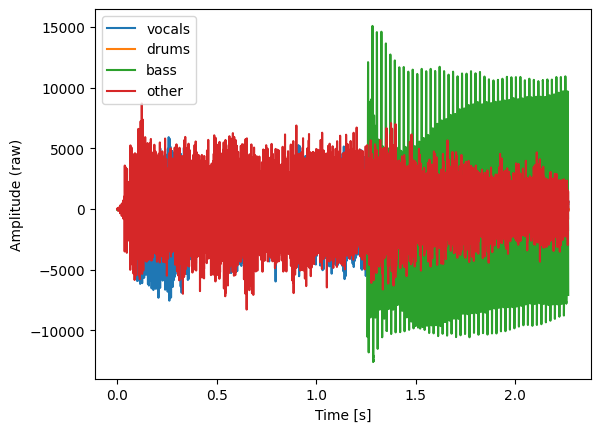

In [14]:
# create time vector
t = np.arange(0,(np.shape(audio_data)[2])/fs, 1/fs)
fig, ax = plt.subplots()
mask = [1,2,3,4]
l1 = ax.plot(t[1:100000], np.swapaxes(audio_data[mask,0,1:100000], 0,1), label = ["vocals", "drums","bass", "other"])
#l2 = ax.plot(t, audio_data[0,1,:], label = "R")
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude (raw)')
ax.legend()
plt.show()

Manually build a mask for just the vocals

(2, 1025, 4924)


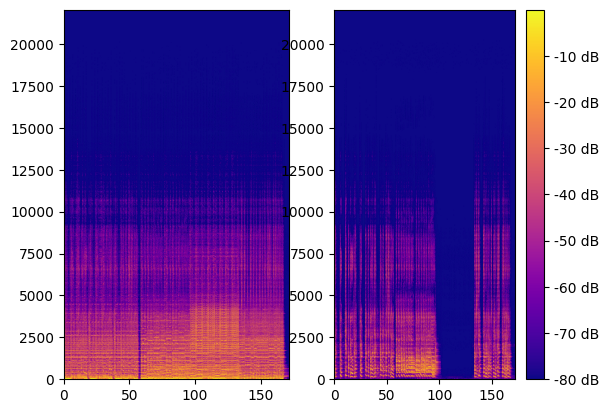

In [15]:
f, t, Xm = stft(audio_data[0,:,:],fs = fs,nperseg=2048, noverlap=512)
f, t, Xv = stft(audio_data[1,:,:],fs = fs,nperseg=2048, noverlap=512)

#Xm = librosa.amplitude_to_db(np.abs(Xm), ref=np.max)
#Xv = librosa.amplitude_to_db(np.abs(Xv), ref=np.max)

print(X.shape)
fig, ax = plt.subplots(1,2)
img0 = ax[0].pcolormesh(t, f, librosa.amplitude_to_db(np.abs(Xm), ref=np.max)[0,:,:], cmap = 'plasma', shading='gouraud')
img1 = ax[1].pcolormesh(t, f, librosa.amplitude_to_db(np.abs(Xv), ref=np.max)[0,:,:], cmap = 'plasma', shading='gouraud')

#ax[0].set_title('Power spectrogram')
fig.colorbar(img0, ax=ax[1], format="%+2.0f dB")
#ax.set_title('STFT Magnitude')
#ax.set_ylabel('Frequency [Hz]')
#ax.set_xlabel('Time [sec]')
plt.show()

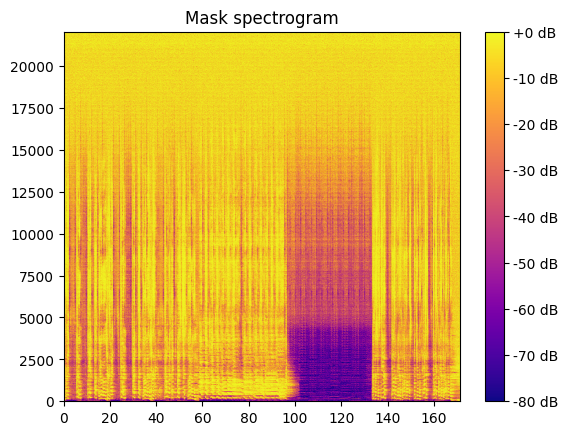

In [16]:
mask = np.abs(Xv) / (np.maximum(np.abs(Xv), np.abs(Xm)) + 1e-8)
# plot mask
fig, ax = plt.subplots()
img = ax.pcolormesh(t, f, librosa.amplitude_to_db(np.abs(mask), ref=np.max)[0,:,:], cmap = 'plasma', shading='gouraud')
ax.set_title('Mask spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()


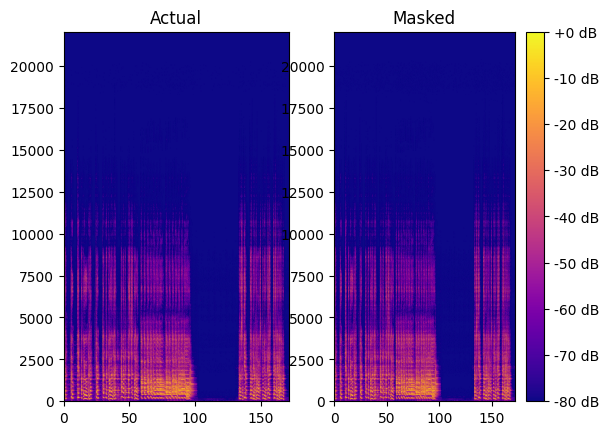

In [17]:
# apply mask
masked = mask * np.abs(Xm)

fig, ax = plt.subplots(1,2)
img0 = ax[0].pcolormesh(t, f, librosa.amplitude_to_db(np.abs(Xv), ref=np.max)[0,:,:], cmap = 'plasma', shading='gouraud')
img1 = ax[1].pcolormesh(t, f, librosa.amplitude_to_db(np.abs(masked), ref=np.max)[0,:,:], cmap = 'plasma', shading='gouraud')

fig.colorbar(img1, ax=ax[1], format="%+2.0f dB")
ax[0].set_title('Actual')
ax[1].set_title('Masked')

plt.show()

In [18]:
mix_phase = np.angle(Xm)
masked = masked * np.exp(1j * mix_phase)
time, vocals2 = istft(masked, fs, nperseg=2048, noverlap=512)
Audio(vocals2[1,1:1000000], rate=fs)

In [19]:
time, vocals1 = istft(Xv, fs, nperseg=2048, noverlap=512)
Audio(vocals1[1,1:1000000], rate=fs)

Convert to torch tensors for correct dimensionality

In [20]:
mix_tensor = torch.from_numpy(np.abs(Xm))
mask_tensor = torch.rand_like(mix_tensor.unsqueeze(-1))

# shapes
print(mix_tensor.shape, mask_tensor.shape)

# masking operation:
masked_tensor = mix_tensor.unsqueeze(-1) * mask_tensor

print(masked_tensor.shape)

# dimensions and order to be used going forward: batch x time x frequency x channel x sources (dummy in the case of mix to broadcast from 1 to multiple sources)
mix_tensor = torch.permute(mix_tensor, (1,2,0)).unsqueeze(0)
print(mix_tensor.shape)

torch.Size([2, 1025, 4924]) torch.Size([2, 1025, 4924, 1])
torch.Size([2, 1025, 4924, 1])
torch.Size([1, 1025, 4924, 2])


my required shape of tensors by model:
nb X freq x timestep x nchannels x sources (sources = n/a for mix, and for mask = 4)

**Todo**: Test batch norm and amplitude to dB functionality

In [21]:
def print_stats(data):
    print(
        f"Shape: {data.shape}\n"
        f"Mean: {data.mean().item()}\n"
        f"Var: {data.var().item()}\n"
    )

test whether torch's batchnorm would work on my data

In [22]:
from torchaudio.transforms import AmplitudeToDB
from torch.nn import BatchNorm2d as BatchNorm
class Model(nn.Module):
    def __init__(self, num_features):
        super().__init__()

        self.amplitude_to_db = AmplitudeToDB()
        self.input_normalization = BatchNorm(num_features, dtype = torch.float64)

    def forward(self, data):
        data = self.amplitude_to_db(data)
        data = self.input_normalization(data)
        return data

num_features = mix_tensor.shape[1]
model = Model(num_features)
output = model(mix_tensor)

print_stats(mix_tensor)
print_stats(output)

Shape: torch.Size([1, 1025, 4924, 2])
Mean: 31.04026355284066
Var: 20241.753592418834

Shape: torch.Size([1, 1025, 4924, 2])
Mean: -2.1624173131650135e-18
Var: 0.9999995320906709



Import, test LSTM layers and see how that goes, might need to reshape input again to get the correct shape, i.e. time before freq or vice versa

Inputs are N (batch size) X L (length. - time dimension) X H (feature dimension = nf * nac)

D = 2 for bidirectional, 1 for directional
H_out = hidden dimension
Outputs are : N,L,D∗H_out

Provide normalized inputs to this

In [23]:
print(mix_tensor.shape)
nrmz = AmplitudeToDB()
nrm_mix = nrmz(mix_tensor)
nrm_mix = torch.permute(nrm_mix, (0,2,1,3))
print(nrm_mix.shape)
nrm_mix = torch.reshape(nrm_mix, (nrm_mix.shape[0],nrm_mix.shape[1],-1))
print(nrm_mix.shape)

torch.Size([1, 1025, 4924, 2])
torch.Size([1, 4924, 1025, 2])
torch.Size([1, 4924, 2050])


In [24]:
from torch.nn import LSTM
nrmz = AmplitudeToDB()
nrm_mix = nrmz(mix_tensor)
print_stats(nrm_mix)
nrm_mix = torch.permute(nrm_mix, (0,2,1,3))
nrm_mix = torch.reshape(nrm_mix, (nrm_mix.shape[0],nrm_mix.shape[1],-1))
nb, nt, H = nrm_mix.shape
recurrent_stack = LSTM(
    input_size = H,
    hidden_size=50,
    num_layers=2,
    batch_first=True,
    bidirectional=True,
    dropout=0.3,
    dtype=torch.float64
)

output, state = recurrent_stack(nrm_mix)
print_stats(output)

Shape: torch.Size([1, 1025, 4924, 2])
Mean: 0.059913122257541376
Var: 151.97267070504003

Shape: torch.Size([1, 4924, 100])
Mean: 0.007628454277147786
Var: 0.02884188038832211



Include the stack into your model!

In [25]:
# input to the model is the mix tensor -  a tensor of the spectrograms

from torchaudio.transforms import AmplitudeToDB
from torch.nn import BatchNorm2d as BatchNorm
from torch.nn import LSTM



class Model(nn.Module):
    def __init__(self, num_features, num_audio_channels, hsize,
                 nlayers, bidi, dropout):
        super().__init__()

        self.amplitude_to_db = AmplitudeToDB()
        self.input_normalization = BatchNorm(num_features, dtype = torch.float64)
        self.recurrent_stack = recurrent_stack = LSTM(
          input_size = num_features * num_audio_channels,
          hidden_size=hsize,
          num_layers=nlayers,
          batch_first=True,
          bidirectional=bool(bidi),
          dropout=0.3,
          dtype=torch.float64
    )

    def forward(self, data):
        data = self.amplitude_to_db(data)
        data = self.input_normalization(data)
        data = torch.permute(data, (0,2,1,3))
        data = torch.reshape(data, (data.shape[0],data.shape[1],-1))
        data = self.recurrent_stack(data)

        return data

nb, nf, nt, nac = mix_tensor.shape
model = Model(nf, nac, 50, 2, True, 0.3)
output, state = model(mix_tensor)

print_stats(mix_tensor)
print_stats(output)

Shape: torch.Size([1, 1025, 4924, 2])
Mean: 31.04026355284066
Var: 20241.753592418834

Shape: torch.Size([1, 4924, 100])
Mean: 0.00045358866773580046
Var: 0.01456398060596108



Add embedding layer to expand back up to mask dimensions!
Target dimensions: (batch, time (stays the same), num_features = freq bins, num_audio_channels = 2, num_sources = 4).

Importing nussl Embedding layer code

In [26]:
class Embedding(torch.nn.Module):
    """
    Maps output from an audio representation module (e.g. RecurrentStack,
    DilatedConvolutionalStack) to an embedding space. The output shape is
    (batch_size, sequence_length, num_features, embedding_size). The embeddings can
    be passed through an activation function. If activation is 'softmax' or
    'sigmoid', and embedding_size is equal to the number of sources, this module
    can be used to implement a mask inference network (or a mask inference
    head in a Chimera network setup).

    Args:
        num_features (int): Number of features being mapped for each frame.
          Either num_frequencies, or if used with MelProjection, num_mels if using
          RecurrentStack. Should be 1 if using DilatedConvolutionalStack.

        hidden_size (int): Size of output from RecurrentStack (hidden_size) or
          DilatedConvolutionalStack (num_filters). If RecurrentStack is bidirectional,
          this should be set to 2 * hidden_size.

        embedding_size (int): Dimensionality of embedding.

        activation (list of str): Activation functions to be applied. Options
          are 'sigmoid', 'tanh', 'softmax', 'relu', 'gate'. Unit normalization can be applied by
          adding 'unit_norm' to the list (e.g. ['sigmoid', unit_norm']). Alternatively,
          L1 normalization can be applied by adding 'l1_norm' to the list.

        dim_to_embed (int): Which dimension of the input to apply the embedding to.
          Defaults to -1 (the last dimension).

        bias (bool): Whether or not to place a bias on the linear layer. Defaults to
          True.

        reshape (bool): Whether to reshape the output of the linear layer to look
          like a time-frequency representation (nb, nt, nf, nc, ...). Defaults to
          True.
    """
    def __init__(self, num_features, hidden_size, embedding_size, activation,
                 num_audio_channels=1, dim_to_embed=-1, bias=True, reshape=True):
        super(Embedding, self).__init__()
        self.add_module(
            'linear',
            nn.Linear(
                hidden_size,
                num_features * num_audio_channels * embedding_size,
                bias=bias, dtype = torch.float64
            )
        )
        self.num_features = num_features
        self.num_audio_channels = num_audio_channels
        self.activation = activation
        self.embedding_size = embedding_size
        self.reshape = reshape

        if 'gated_tanh' in self.activation:
            self.embed_linear = nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.Tanh()
            )
            self.embed_gate = nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.Sigmoid()
            )

        if isinstance(dim_to_embed, int):
            dim_to_embed = [dim_to_embed]

        self.dim_to_embed = dim_to_embed

        for name, param in self.linear.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                nn.init.xavier_normal_(param)

    def forward(self, data):
        """
        Args:
            data: output from RecurrentStack or ConvolutionalStack. Shape is:
              (num_batch, ..., hidden_size or num_filters)

        Returns:
            An embedding (with an optional activation) for each point in the
              representation of shape (num_batch, ..., embedding_size).
        """
        shape = list(data.shape)
        _dims = []
        for _dim in self.dim_to_embed:
            # move each dimension to embed to end of tensor
            if _dim == -1:
                _dim = len(shape) - 1
            data = data.transpose(_dim, -1)
            _dims.append(_dim)

        # the new shape doesn't have the embedded dimensions
        shape = [
            v for i, v in enumerate(shape)
            if i not in _dims
        ]

        shape = tuple(shape)
        data = data.reshape(shape + (-1,))

        if 'gated_tanh' in self.activation:
            data = self.embed_linear(data) * self.embed_gate(data)

        data = self.linear(data)

        if self.reshape:
            shape = shape + (
                self.num_features, self.num_audio_channels, self.embedding_size,)
            data = data.reshape(shape)

        if 'sigmoid' in self.activation:
            data = torch.sigmoid(data)
        elif 'tanh' in self.activation:
            data = torch.tanh(data)
        elif 'relu' in self.activation:
            data = torch.relu(data)
        elif 'softmax' in self.activation:
            data = torch.softmax(data, dim=-1)

        if 'unit_norm' in self.activation:
            data = nn.functional.normalize(data, dim=-1, p=2)
        elif 'l1_norm' in self.activation:
            data = nn.functional.normalize(data, dim=-1, p=1)

        return data



In [27]:
#from torch.nn import Embedding
num_sources = 1 # v,d,b,0
num_audio_channels = 2
activation = 'sigmoid'
hidden_size = 50
num_embeddings = output.shape[-1] # input dimension of embeddings = hidden dimension
embed_dim = num_features*num_audio_channels*num_sources
embed_layer = Embedding(num_features, 2*hidden_size, num_sources, activation,
                                   num_audio_channels)
embed_output = embed_layer(output)

print_stats(output)
print_stats(embed_output)

# reshape embedding output

Shape: torch.Size([1, 4924, 100])
Mean: 0.00045358866773580046
Var: 0.01456398060596108

Shape: torch.Size([1, 4924, 1025, 2, 1])
Mean: 0.5000413860239165
Var: 8.575049544466556e-05



plot the untrained mask produced


<ipython-input-28-33d713fa49ff>:4: RuntimeWarning: divide by zero encountered in log10
  ax[0].imshow(20 * np.log10(np.abs(Xm)[0,...]), origin='lower', aspect='auto')


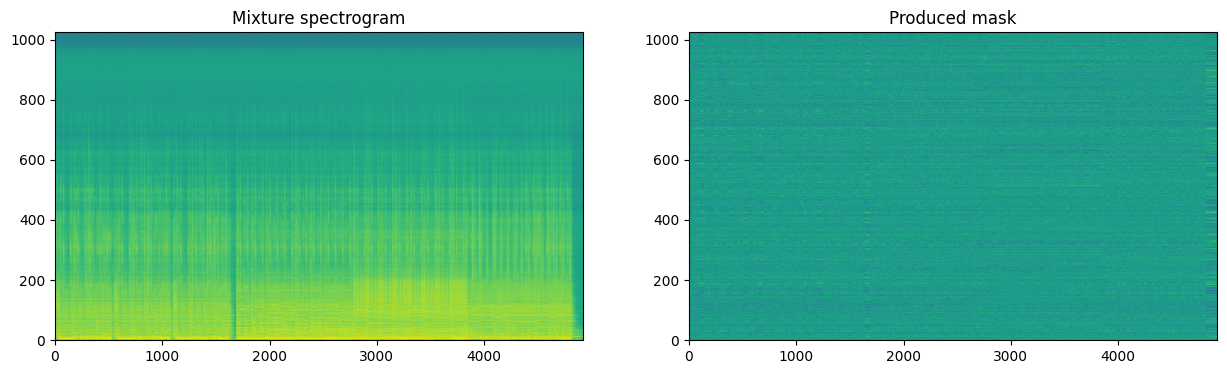

In [28]:
mask = to_numpy(embed_output[0, ..., 0]) # mask for first channel, that is vocals

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].imshow(20 * np.log10(np.abs(Xm)[0,...]), origin='lower', aspect='auto')
ax[0].set_title('Mixture spectrogram')
ax[1].imshow(mask[..., 0].T, origin='lower', aspect='auto')
ax[1].set_title('Produced mask')
plt.show()

<ipython-input-29-295737c1d532>:6: RuntimeWarning: divide by zero encountered in log10
  ax[0].imshow(20 * np.log10(np.abs(Xm)[0,...,]), origin='lower', aspect='auto')
<ipython-input-29-295737c1d532>:8: RuntimeWarning: divide by zero encountered in log10
  ax[1].imshow(20 * np.log10(estimate[..., 0].T), origin='lower', aspect='auto')


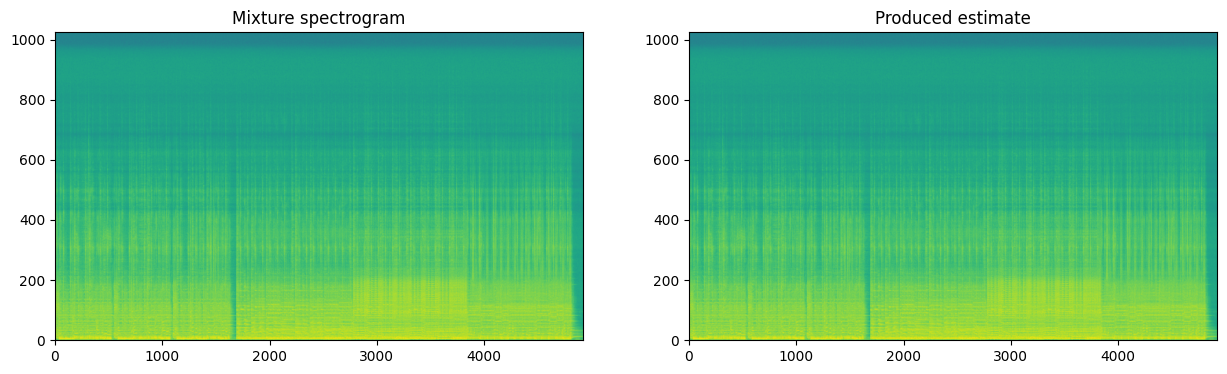

In [29]:
estimates = torch.permute(mix_tensor, (0,2,1,3)).unsqueeze(-1) * embed_output

estimate = to_numpy(estimates[0, ..., 0])

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].imshow(20 * np.log10(np.abs(Xm)[0,...,]), origin='lower', aspect='auto')
ax[0].set_title('Mixture spectrogram')
ax[1].imshow(20 * np.log10(estimate[..., 0].T), origin='lower', aspect='auto')
ax[1].set_title('Produced estimate')
plt.show()

Put everything inside the model!

In [35]:
from torchaudio.transforms import AmplitudeToDB
from torch.nn import BatchNorm2d as BatchNorm
from torch.nn import LSTM



class Model(nn.Module):
    def __init__(self, num_features, num_audio_channels, hsize,
                 nlayers, bidi, dropout, num_sources, activation='sigmoid' ):
        super().__init__()

        self.amplitude_to_db = AmplitudeToDB()
        self.input_normalization = BatchNorm(num_features, dtype = torch.float64)
        self.recurrent_stack = recurrent_stack = LSTM(
          input_size = num_features * num_audio_channels,
          hidden_size=hsize,
          num_layers=nlayers,
          batch_first=True,
          bidirectional=bool(bidi),
          dropout=0.3,
          dtype=torch.float64
    )
        hidden_size = hsize * (int(bidi) + 1)
        self.embedding = Embedding(num_features, hidden_size,
                                   num_sources, activation,
                                   num_audio_channels)

    def forward(self, data):
        mix_magnitude = torch.permute(data, (0,2,1,3))
        data = self.amplitude_to_db(data)
        data = self.input_normalization(data)
        data = torch.permute(data, (0,2,1,3))
        data = torch.reshape(data, (data.shape[0],data.shape[1],-1))
        data, state = self.recurrent_stack(data)
        mask = self.embedding(data)
        estimates = mix_magnitude.unsqueeze(-1) * mask
        return estimates


nb, nf, nt, nac = mix_tensor.shape
model = Model(nf, nac, 50, 2, True, 0.3, 4, 'sigmoid')
output = model(mix_tensor)

print_stats(mix_tensor)
print_stats(output)

Shape: torch.Size([1, 1025, 4924, 2])
Mean: 31.04026355284066
Var: 20241.753592418834

Shape: torch.Size([1, 4924, 1025, 2, 4])
Mean: 15.525691725523778
Var: 5069.753596731824



<ipython-input-36-cb560e41e40a>:4: RuntimeWarning: divide by zero encountered in log10
  ax[0].imshow(20 * np.log10(np.abs(Xm)[0,...,]), origin='lower', aspect='auto')
<ipython-input-36-cb560e41e40a>:6: RuntimeWarning: divide by zero encountered in log10
  ax[1].imshow(20 * np.log10(estimate[..., 0].T), origin='lower', aspect='auto')


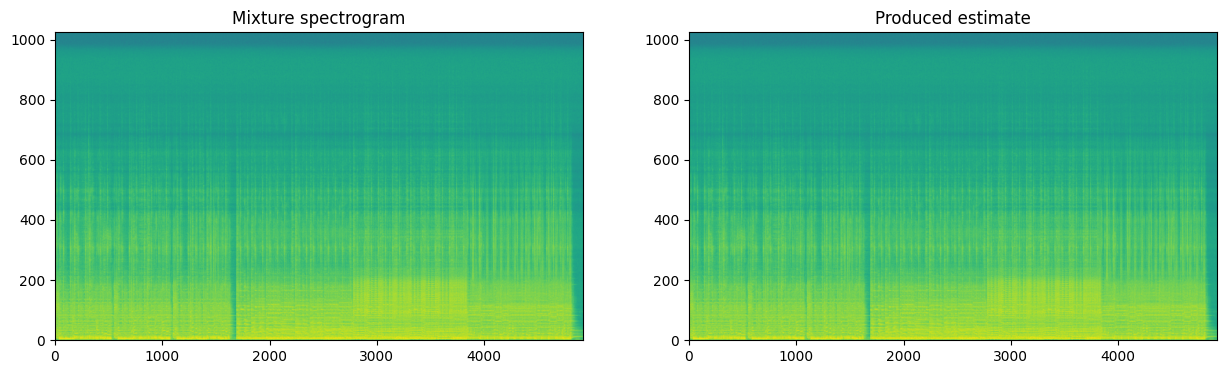

In [36]:
estimate = to_numpy(output[0, ..., 0])

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].imshow(20 * np.log10(np.abs(Xm)[0,...,]), origin='lower', aspect='auto')
ax[0].set_title('Mixture spectrogram')
ax[1].imshow(20 * np.log10(estimate[..., 0].T), origin='lower', aspect='auto')
ax[1].set_title('Produced estimate')
plt.show()

Include STFT within the model